In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import cpi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from io import StringIO

# Statmodels & patsy
import patsy
import statsmodels.api as sm

from scipy.stats import pearsonr, norm, ttest_ind

In [2]:
# New Dataframe. Make sure to import the movies_metatdata.csv file from
# https://www.kaggle.com/rounakbanik/the-movies-dataset/version/7#movies_metadata.csv
df = pd.read_csv("movies_metadata.csv", dtype=object)

In [3]:
# Dropping columns except for: budget, genres, release_date, revenue, runtime, title, vote_average
# Dropped: vote_count, video, tagline, status, spoken_languages, production_countries, 
#          production_companies, poster_path, popularity, overview, original)title, 
#          original_language, imdb_id, id, homepage, belongs_to_collection, adult
df = df.drop(['vote_count'], axis = 1)
df = df.drop(['video'], axis = 1)
df = df.drop(['tagline'], axis = 1)
df = df.drop(['status'], axis = 1)
df = df.drop(['spoken_languages'], axis = 1)
df = df.drop(['production_countries'], axis = 1)
df = df.drop(['production_companies'], axis = 1)
df = df.drop(['poster_path'], axis = 1)
df = df.drop(['popularity'], axis = 1)
df = df.drop(['overview'], axis = 1)
df = df.drop(['original_title'], axis = 1)
df = df.drop(['original_language'], axis = 1)
df = df.drop(['imdb_id'], axis = 1)
df = df.drop(['id'], axis = 1)
df = df.drop(['homepage'], axis = 1)
df = df.drop(['belongs_to_collection'], axis = 1)
df = df.drop(['adult'], axis = 1)

In [4]:
# Checking for: budget, genres, release_date, revenue, runtime, title, vote_average
print(df.columns.values)

print('original shape: ', df.shape)

['budget' 'genres' 'release_date' 'revenue' 'runtime' 'title'
 'vote_average']
original shape:  (45466, 7)


In [5]:
# Removing films with unlisted budget
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df = df.dropna(subset = ['budget'])

# Removing films with budget less than $1 Million
df['budget'] = df['budget'].astype(int)
df = df[df['budget']>=1000000]

print('after budget clean: ', df.shape)

after budget clean:  (7405, 7)


In [6]:
# Removing films with unlisted revenue
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df = df.dropna(subset = ['revenue'])

# Removing films with revenue less than $1 Million
df['revenue'] = df['revenue'].astype(int)
df = df[df['revenue']>=1000000]

print('after revenue clean: ', df.shape)

after revenue clean:  (4636, 7)


In [7]:
# Convert date to Year Month Day... YYYY MM DD
df["release_date"] = pd.to_datetime(df["release_date"]).dt.strftime("%Y%m%d")

# Fixing values of vote_average
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
df = df.dropna(subset = ['vote_average'])

# Removing films with missing runtime
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df = df[df['runtime']>=1]
# 4630 rows x 7 columns

print('after runtime clean: ', df.shape)

after runtime clean:  (4629, 7)


In [8]:
# adjusting revenue and budget for inflation to 2018 as base year (latest year in cpi data)

for index, row in df.iterrows():
    year = int(str(row["release_date"])[:4])
    df.loc[index, "adjusted_revenue"] = cpi.inflate(row["revenue"], year)
    
for index, row in df.iterrows():
    year = int(str(row["release_date"])[:4])
    df.loc[index, "adjusted_budget"] = cpi.inflate(row["budget"], year) 

In [9]:
# print(df[[""release_date", "revenue"", "adjusted_revenue", "budget", "adjusted_budget"]])
print(df[["genres", "adjusted_budget", "adjusted_revenue"]])

                                                  genres  adjusted_budget  \
0      [{'id': 16, 'name': 'Animation'}, {'id': 35, '...     4.943051e+07   
1      [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...     1.070994e+08   
3      [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...     2.636294e+07   
5      [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...     9.886102e+07   
8      [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...     5.766893e+07   
9      [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...     9.556566e+07   
10     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...     1.021564e+08   
13     [{'id': 36, 'name': 'History'}, {'id': 18, 'na...     7.249808e+07   
14     [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...     1.614730e+08   
15     [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...     8.567955e+07   
16     [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...     2.718678e+07   
17     [{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...     6.590735e+06   

# Descriptive Stats

In [10]:
# Replacing genres tag with numerical values
value = ''
for a in df['genres']: 
    value = re.sub('[^0-9]+',' ', a)
    df['genres'] = df['genres'].replace(a, value)
value = 'genre'
for a in df['genres']: 
    value += re.sub(' ','\n', a)
value = StringIO(value)
ndf = pd.read_csv(value, sep=" ")
ndf['genre_tags'] = ndf['genre'].value_counts()
ndf = ndf.dropna(subset = ['genre_tags'])
ndf = ndf.drop(['genre'], axis = 1)

# Setting up genre tags for later
value = ''
for a in df['genres']: 
    value = re.sub(' ',',', a)
    value = value[1:]
    value, sep, tail = value.partition(',')  
    df['genres'] = df['genres'].replace(a, value)
    
#replaces genre with numerical ranking

df['genres'] = df['genres'].replace(str(12), int('0'))
df['genres'] = df['genres'].replace(str(14), int('1'))
df['genres'] = df['genres'].replace(str(16), int('2'))
df['genres'] = df['genres'].replace(str(18), int('3'))
df['genres'] = df['genres'].replace(str(27), int('4'))
df['genres'] = df['genres'].replace(str(28), int('5'))
df['genres'] = df['genres'].replace(str(35), int('6')) 
df['genres'] = df['genres'].replace(str(36), int('7'))
df['genres'] = df['genres'].replace(str(37), int('8'))
df['genres'] = df['genres'].replace(str(53), int('9'))
df['genres'] = df['genres'].replace(str(80), int('10'))
df['genres'] = df['genres'].replace(str(99), int('11'))
df['genres'] = df['genres'].replace(str(878), int('12'))
df['genres'] = df['genres'].replace(str(9648), int('13'))
df['genres'] = df['genres'].replace(str(10402), int('14'))
df['genres'] = df['genres'].replace(str(10749), int('15'))
df['genres'] = df['genres'].replace(str(10751), int('16'))
df['genres'] = df['genres'].replace(str(10752), int('17'))
df['genres'] = df['genres'].replace(str(10769), int('18'))
df['genres'] = df['genres'].replace(str(10770), int('19'))
df['genres'] = pd.to_numeric(df['genres'],errors='coerce')
df = df.dropna(subset = ['genres'])

# budget, genres, release_date, revenue, runtime, vote_average

In [11]:
df.dtypes

budget                int32
genres              float64
release_date         object
revenue               int32
runtime             float64
title                object
vote_average        float64
adjusted_revenue    float64
adjusted_budget     float64
dtype: object

In [12]:
stats = df.describe(include='all')
stats

,budget,genres,release_date,revenue,runtime,title,vote_average,adjusted_revenue,adjusted_budget
count,4.622000e+03,4622.000000,4622,4.622000e+03,4622.000000,4622,4622.000000,4.622000e+03,4.622000e+03
unique,NaN,NaN,3392,NaN,NaN,4546,NaN,NaN,NaN
top,NaN,NaN,20141225,NaN,NaN,Beauty and the Beast,NaN,NaN,NaN
freq,NaN,NaN,7,NaN,NaN,3,NaN,NaN,NaN
mean,3.549948e+07,5.251406,NaN,1.038206e+08,111.356339,NaN,6.296625,1.563223e+08,4.916073e+07
std,4.147832e+07,3.590119,NaN,1.706188e+08,21.170990,NaN,0.872260,2.780908e+08,5.051805e+07
min,1.000000e+06,0.000000,NaN,1.000000e+06,26.000000,NaN,1.000000,1.064019e+06,1.059447e+06
25%,8.500000e+06,3.000000,NaN,1.331259e+07,97.000000,NaN,5.800000,2.177820e+07,1.494685e+07
50%,2.000000e+07,5.000000,NaN,4.099833e+07,107.000000,NaN,6.300000,6.816945e+07,3.233734e+07
75%,4.500000e+07,6.000000,NaN,1.175536e+08,122.000000,NaN,6.900000,1.786886e+08,6.490655e+07


In [13]:
df.head()

,budget,genres,release_date,revenue,runtime,title,vote_average,adjusted_revenue,adjusted_budget
0,30000000,2.0,19951030,373554033,81.0,Toy Story,7.7,6.154989e+08,4.943051e+07
1,65000000,0.0,19951215,262797249,104.0,Jumanji,6.9,4.330068e+08,1.070994e+08
3,16000000,6.0,19951222,81452156,127.0,Waiting to Exhale,6.1,1.342074e+08,2.636294e+07
5,60000000,5.0,19951215,187436818,170.0,Heat,7.7,3.088366e+08,9.886102e+07
8,35000000,5.0,19951222,64350171,106.0,Sudden Death,5.5,1.060287e+08,5.766893e+07


In [14]:
df_final = df
df = df.sample(3241)
df_test = pd.concat([df_final, df]).drop_duplicates(keep = False)
df.shape

(3241, 9)

In [15]:
df_test.shape

(1379, 9)

In [16]:
df_final.shape

(4622, 9)

0 = adventure 1 = fantasy 2 = animation 3 = drama 4 = horror 5 = action 6 = comedy 7 = history 8 = western 9 = thriller 10 = crime 11 = documentary 12 = science fiction 13 = mystery 14 = music 15 = romance 16 = family 17 = war 18 = foreign 19 = tv movie


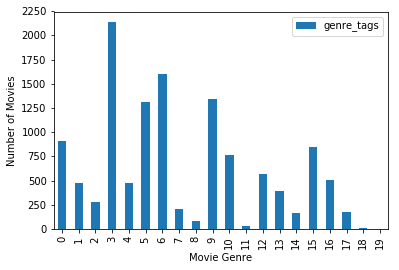

In [17]:
# genres ranges from 1 to 20
# each bar represents a genre
#ndf = ndf.reset_index(drop=True)
ndf = ndf.reset_index(drop=True)
ndf.plot.bar()
plt.xlabel('Movie Genre')
plt.ylabel('Number of Movies')
f2 = plt.gcf()
# Tags
# 0 = adventure
# 1 = fantasy
# 2 = animation
# 3 = drama
# 4 = horror
# 5 = action
# 6 = comedy
# 7 = history
# 8 = western
# 9 = thriller
# 10 = crime
# 11 = documentary
# 12 = science fiction
# 13 = mystery
# 14 = music
# 15 = romance
# 16 = family
# 17 = war
# 18 = foreign
# 19 = tv movie
print('0 = adventure', 
'1 = fantasy',
'2 = animation',
'3 = drama',
'4 = horror',
'5 = action',
'6 = comedy',
'7 = history',
'8 = western',
'9 = thriller',
'10 = crime',
'11 = documentary',
'12 = science fiction',
'13 = mystery',
'14 = music',
'15 = romance',
'16 = family',
'17 = war',
'18 = foreign',
'19 = tv movie')

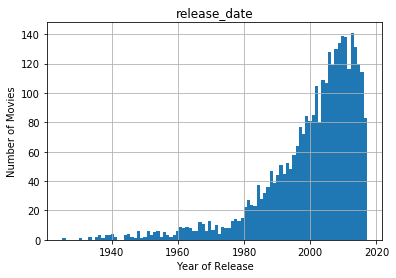

In [18]:
# release_date ranges from 1924 to 2017
# each bar represents a range of 1 Year
df['release_date'] = df['release_date'].astype(int)
df['release_date'] /= 10000
df.hist(column='release_date', bins=94)
f3 = plt.gcf()
# plt.xlabel('Each bar = 1 Year')
plt.xlabel('Year of Release')
plt.ylabel('Number of Movies')
df['release_date'] *= 10000

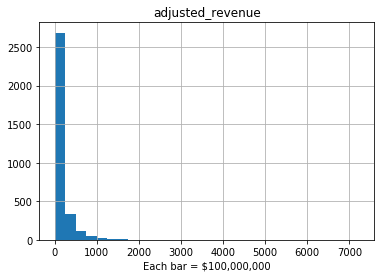

In [19]:
# revenue ranges from 1Million to 2.8Billion
# each bar represents a range of 100Million
df['adjusted_revenue'] /= 1000000
df.hist(column='adjusted_revenue', bins=29)
f4 = plt.gcf()
plt.xlabel('Each bar = $100,000,000')
df['adjusted_revenue'] *= 1000000

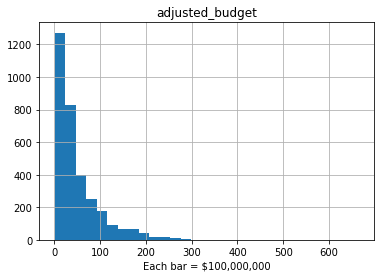

In [20]:
# each bar represents a range of 100Million
df['adjusted_budget'] /= 1000000
df.hist(column='adjusted_budget', bins=29)
f4 = plt.gcf()
plt.xlabel('Each bar = $100,000,000')
df['adjusted_budget'] *= 1000000

In [21]:
# need to log transform budget and revenue because they're skewed
df["budget10"] = np.log10(df["adjusted_budget"])
df["revenue10"] = np.log10(df["adjusted_revenue"])

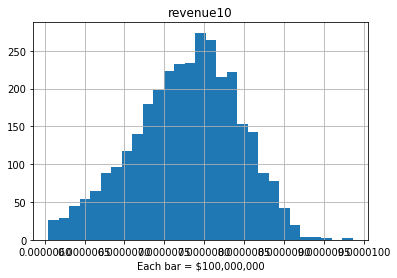

In [22]:
# revenue ranges from 1Million to 2.8Billion
# each bar represents a range of 100Million
df['revenue10'] /= 1000000
df.hist(column='revenue10', bins=29)
f4 = plt.gcf()
plt.xlabel('Each bar = $100,000,000')
df['revenue10'] *= 1000000

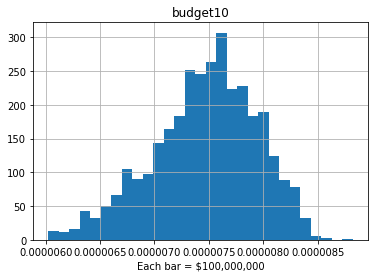

In [23]:
# each bar represents a range of 100Million
df['budget10'] /= 1000000
df.hist(column='budget10', bins=29)
f4 = plt.gcf()
plt.xlabel('Each bar = $100,000,000')
df['budget10'] *= 1000000

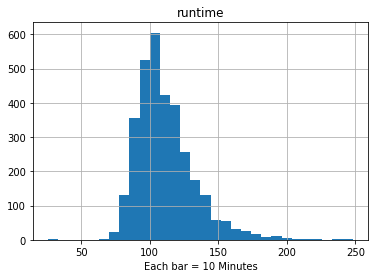

In [24]:
# runtime ranges from 26Min to 320Min
# each bar represents a range of 10Min
df['runtime'] = df['runtime'].astype(int)
df.hist(column='runtime', bins=30)
plt.xlabel('Each bar = 10 Minutes')
f5 = plt.gcf()

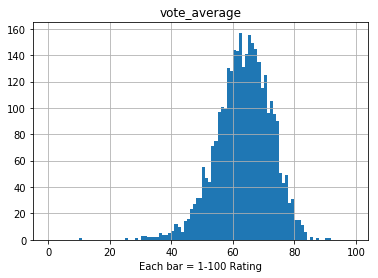

In [25]:
# vote ranges from 1 to 100
# each bar represents a range of 1
df['vote_average'] *= 10
df['vote_average'] = df['vote_average'].astype(int)
df.hist(column='vote_average', bins=range(99+1))
f7 = plt.gcf()
plt.xlabel('Each bar = 1-100 Rating')
df['vote_average'] = df['vote_average'].astype(float)
df['vote_average'] /= 10

In [26]:
print(df[['release_date', 'revenue10']])

       release_date  revenue10
10979    20060608.0   8.759994
18824    20110121.0   7.165121
2528     19830617.0   8.281559
1250     19851213.0   7.689575
5509     19891117.0   6.360327
23753    20140730.0   8.913959
367      19940218.0   7.531771
6856     19721014.0   8.336719
3319     19910322.0   8.157776
10105    20050610.0   7.950679
4934     20020123.0   8.022170
20021    20120831.0   6.705058
3080     19731213.0   8.478934
1350     19961218.0   7.311558
17935    20110928.0   8.523855
17522    20100917.0   7.655683
9279     20010118.0   6.737094
11152    20060831.0   7.728140
402      19941212.0   7.180669
1217     19630620.0   7.983971
2032     19861121.0   8.287121
13602    20090311.0   8.202749
9002     19920814.0   6.937345
36982    20081113.0   7.367839
39335    20160721.0   8.192439
13803    20090618.0   7.863248
1207     19740620.0   8.184133
12516    20071009.0   7.624588
6648     19911210.0   7.956887
2005     19830325.0   7.929199
...             ...        ...
2220    

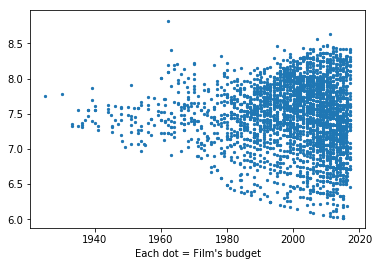

In [27]:
# budget, genres, revenue, runtime, vote_average over release_date
# Relationship of budget over time
df['release_date'] /= 10000
plt.scatter(df['release_date'], df['budget10'], s=5)
budget_plot = plt.gcf()
plt.xlabel('Each dot = Film\'s budget')
df['release_date'] *= 10000

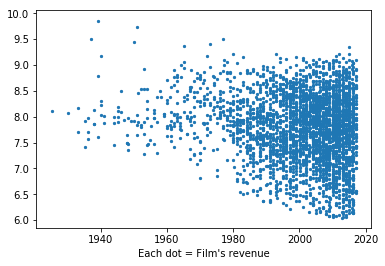

In [28]:
# Relationship of revenue over time
df['release_date'] /= 10000
df['revenue10'] #/= 10000000
plt.scatter(df['release_date'], df['revenue10'], s=5)
revenue_plot = plt.gcf()
plt.xlabel('Each dot = Film\'s revenue')
df['release_date'] *= 10000
# df['revenue10'] *= 10000000

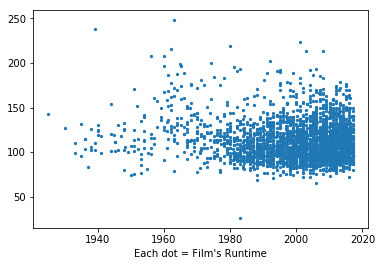

In [29]:
# Relationship of runtime over time
df['release_date'] /= 10000
plt.scatter(df['release_date'], df['runtime'], s=5)
budget_plot = plt.gcf()
plt.xlabel('Each dot = Film\'s Runtime')
df['release_date'] *= 10000

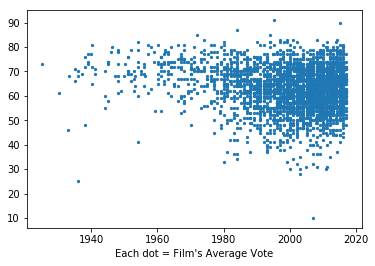

In [30]:
# Relationship of vote average over time
df['release_date'] /= 10000
df['vote_average'] *= 10
plt.scatter(df['release_date'], df['vote_average'], s=5)
budget_plot = plt.gcf()
plt.xlabel('Each dot = Film\'s Average Vote')
df['release_date'] *= 10000
df['vote_average'] *= 10

In [31]:
# basic description of dataset
desc = df.describe()
print(desc)

             budget       genres  release_date       revenue     runtime  \
count  3.241000e+03  3241.000000  3.241000e+03  3.241000e+03  3241.00000   
mean   3.533132e+07     5.234496  2.000372e+07  1.018488e+08   111.33971   
std    4.171426e+07     3.578562  1.462279e+05  1.661660e+08    21.09977   
min    1.000000e+06     0.000000  1.925123e+07  1.000000e+06    26.00000   
25%    8.000000e+06     3.000000  1.994103e+07  1.308207e+07    97.00000   
50%    2.000000e+07     5.000000  2.004093e+07  4.049276e+07   107.00000   
75%    4.500000e+07     6.000000  2.011032e+07  1.176989e+08   122.00000   
max    3.800000e+08    18.000000  2.017080e+07  2.068224e+09   248.00000   

       vote_average  adjusted_revenue  adjusted_budget     budget10  \
count   3241.000000      3.241000e+03     3.241000e+03  3241.000000   
mean     629.330454      1.555241e+08     4.906401e+07     7.467810   
std       87.994541      2.883990e+08     5.085317e+07     0.477981   
min      100.000000      1.1151

In [32]:
# pairwise correlations between variables
corrs = df.corr()
print(corrs)

                    budget    genres  release_date   revenue   runtime  \
budget            1.000000 -0.104491      0.288831  0.724975  0.149859   
genres           -0.104491  1.000000      0.012906 -0.084201 -0.064466   
release_date      0.288831  0.012906      1.000000  0.171409 -0.110408   
revenue           0.724975 -0.084201      0.171409  1.000000  0.154424   
runtime           0.149859 -0.064466     -0.110408  0.154424  1.000000   
vote_average     -0.029357 -0.022966     -0.168823  0.166706  0.371642   
adjusted_revenue  0.429400 -0.087218     -0.130856  0.741565  0.193012   
adjusted_budget   0.930288 -0.107672      0.064765  0.670261  0.229549   
budget10          0.755984 -0.086673     -0.035196  0.513216  0.194206   
revenue10         0.524066 -0.078393     -0.151675  0.674073  0.175186   

                  vote_average  adjusted_revenue  adjusted_budget  budget10  \
budget               -0.029357          0.429400         0.930288  0.755984   
genres               -0.022

Text(0, 0.5, 'Revenue in Millions')

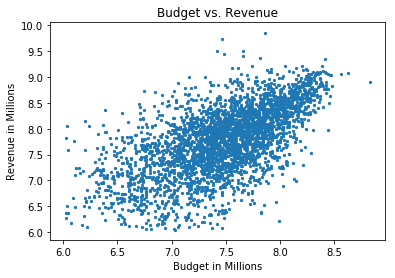

In [33]:
# Relationship of budget to revenue
plt.title('Budget vs. Revenue')
# rev = df['adjusted_revenue']/1000000
# bud = df['adjusted_budget']/1000000
plt.scatter(df['budget10'], df['revenue10'], s=5)
plt.xlabel('Budget in Millions')
plt.ylabel('Revenue in Millions')

Text(0, 0.5, 'Revenue in Millions')

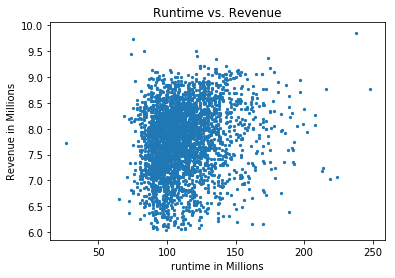

In [34]:
# Relationship of runtime to revenue
plt.title('Runtime vs. Revenue')
# rev = df['adjusted_revenue']/1000000
# bud = df['adjusted_budget']/1000000
plt.scatter(df['runtime'], df['revenue10'], s=5)
plt.xlabel('runtime in Millions')
plt.ylabel('Revenue in Millions')

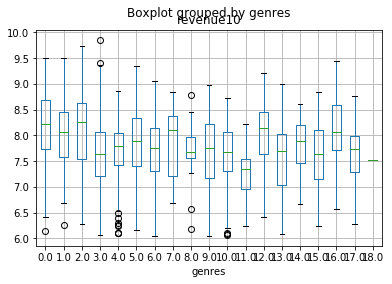

In [35]:
# Relationship of genre to revenue

# rev = df['adjusted_revenue']/1000000
gen_rev = df.boxplot(column=['revenue10'], by='genres')
# plt.margins(0.1)
# plt.xlabel('Genre')
# plt.ylabel('Revenue in Millions')

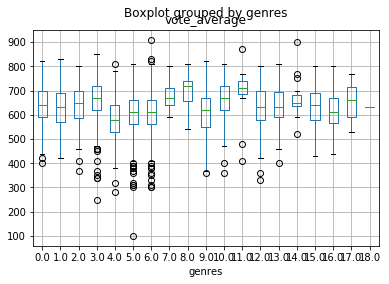

In [36]:
# Relationship of genre to vote average
# bud = df['adjusted_budget']/1000000
gen_bud = df.boxplot(column=['vote_average'], by= 'genres')
# plt.margins(0.1)
# plt.xlabel('Genre')
# plt.ylabel('Budget in Millions')

In [37]:
# TODO: how should we do this? the actual rev - bud or the log transformed values?
# # Relationship of genre to budget
# # Profit = revenue - budget
# plt.title('Profit by Genre')
# bud = df['adjusted_budget']/1000000
# rev = df['adjusted_revenue']/1000000
# plt.scatter(df['genres'], (rev-bud), s=5)
# plt.margins(0.1)
# plt.xlabel('Genre')
# plt.ylabel('Profit in Millions')

In [38]:
# # Relationship of genre to budget
# # Profit percentage = (revenue - budget)/budget
# plt.title('Profit percentage by Genre')
# bud = df['adjusted_budget']/1000000
# rev = df['adjusted_revenue']/1000000
# plt.scatter(df['genres'], ((rev-bud)/bud), s=5)
# plt.margins(0.1)
# plt.xlabel('Genre')
# plt.ylabel('Profit Percentage')

# # rank the genres by avg profit margin
# # same for vote average of each genre

Text(0, 0.5, 'Vote Average')

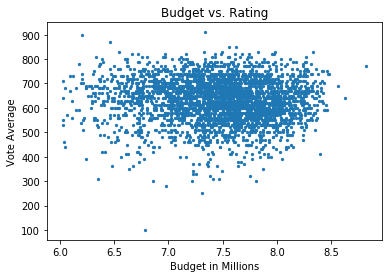

In [39]:
# Relationship between budget and rating
plt.title('Budget vs. Rating')
# bud = df['adjusted_budget']/1000000
plt.scatter(df['budget10'], df['vote_average'], s=5)
plt.xlabel('Budget in Millions')
plt.ylabel('Vote Average')

# no trend of increasing budget = higher vote average

Text(0, 0.5, 'Vote Average')

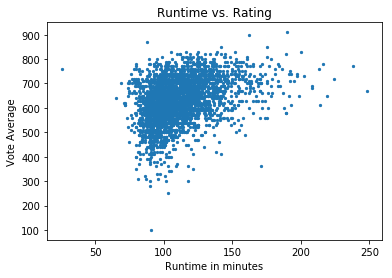

In [40]:
# Relationship between budget and rating
plt.title('Runtime vs. Rating')
# bud = df['adjusted_budget']/1000000
plt.scatter(df['runtime'], df['vote_average'], s=5)
plt.xlabel('Runtime in minutes')
plt.ylabel('Vote Average')



Text(0, 0.5, 'Vote Average')

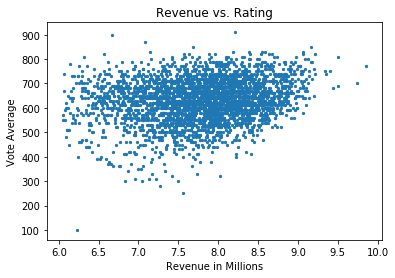

In [41]:
#Relationship between revenue and rating
plt.title('Revenue vs. Rating')
rev = df['adjusted_revenue']/1000000
plt.scatter(df['revenue10'], df['vote_average'], s=5)
plt.xlabel('Revenue in Millions')
plt.ylabel('Vote Average')

#no trend of increasing revenue = higher vote average

Text(0.5, 1.0, 'Year vs. Revenue')

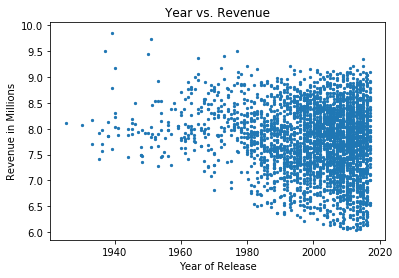

In [42]:
# Relationship between year of release and revenue

year = df['release_date'].astype(int)
year /= 10000
# rev = df['adjusted_revenue']/1000000
plt.scatter(year, df['revenue10'], s=5)
plt.xlabel('Year of Release')
plt.ylabel('Revenue in Millions')
plt.title('Year vs. Revenue')

Text(0.5, 1.0, 'Year vs. Rating')

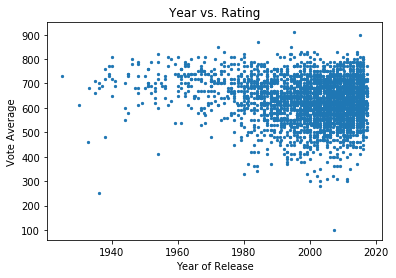

In [43]:
# Vote trend over time

year = df['release_date'].astype(int)
year /= 10000
plt.scatter(year, df['vote_average'], s=5)
plt.xlabel('Year of Release')
plt.ylabel('Vote Average')
plt.title('Year vs. Rating')

# Linear Regression

We must treat genres as objects to use statsmodels/sklearn package functions

In [44]:
df['genres'] = df['genres'].astype(object)

In [45]:
outcome, predictors = patsy.dmatrices('vote_average ~ budget', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.794
Date:                Fri, 31 May 2019   Prob (F-statistic):             0.0947
Time:                        16:23:04   Log-Likelihood:                -19108.
No. Observations:                3241   AIC:                         3.822e+04
Df Residuals:                    3239   BIC:                         3.823e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    631.5184      2.025    311.838      0.0

In [46]:
outcome, predictors = patsy.dmatrices('vote_average ~ revenue', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     92.59
Date:                Fri, 31 May 2019   Prob (F-statistic):           1.25e-21
Time:                        16:23:04   Log-Likelihood:                -19063.
No. Observations:                3241   AIC:                         3.813e+04
Df Residuals:                    3239   BIC:                         3.814e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    620.3392      1.788    346.967      0.0

In [47]:
outcome, predictors = patsy.dmatrices('vote_average ~ runtime', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     519.1
Date:                Fri, 31 May 2019   Prob (F-statistic):          1.08e-106
Time:                        16:23:04   Log-Likelihood:                -18868.
No. Observations:                3241   AIC:                         3.774e+04
Df Residuals:                    3239   BIC:                         3.775e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    456.7654      7.709     59.250      0.0

In [48]:
outcome, predictors = patsy.dmatrices('revenue ~ budget', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     3588.
Date:                Fri, 31 May 2019   Prob (F-statistic):               0.00
Time:                        16:23:04   Log-Likelihood:                -64737.
No. Observations:                3241   AIC:                         1.295e+05
Df Residuals:                    3239   BIC:                         1.295e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.842e+05   2.64e+06     -0.070      0.9

In [49]:
outcome, predictors = patsy.dmatrices('revenue ~ runtime', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     79.13
Date:                Fri, 31 May 2019   Prob (F-statistic):           9.48e-19
Time:                        16:23:04   Log-Likelihood:                -65906.
No. Observations:                3241   AIC:                         1.318e+05
Df Residuals:                    3239   BIC:                         1.318e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.355e+07   1.55e+07     -2.166      0.0

In [50]:
outcome, predictors = patsy.dmatrices('vote_average ~ genres', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     18.67
Date:                Fri, 31 May 2019   Prob (F-statistic):           2.86e-57
Time:                        16:23:04   Log-Likelihood:                -18948.
No. Observations:                3241   AIC:                         3.793e+04
Df Residuals:                    3222   BIC:                         3.805e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        637.2464      5.054    126.

In [51]:
outcome, predictors = patsy.dmatrices('revenue ~ genres', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     21.87
Date:                Fri, 31 May 2019   Prob (F-statistic):           5.28e-68
Time:                        16:23:04   Log-Likelihood:                -65759.
No. Observations:                3241   AIC:                         1.316e+05
Df Residuals:                    3222   BIC:                         1.317e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.188e+08   9.47e+06     23.

In [52]:
outcome, predictors = patsy.dmatrices('vote_average ~ runtime + adjusted_budget + genres', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     39.81
Date:                Fri, 31 May 2019   Prob (F-statistic):          3.07e-138
Time:                        16:23:04   Log-Likelihood:                -18751.
No. Observations:                3241   AIC:                         3.754e+04
Df Residuals:                    3220   BIC:                         3.767e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         473.4683      9.652     

In [53]:
outcome, predictors = patsy.dmatrices('adjusted_revenue ~ runtime + adjusted_budget + genres', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       adjusted_revenue   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     54.81
Date:                Fri, 31 May 2019   Prob (F-statistic):          1.23e-187
Time:                        16:23:04   Log-Likelihood:                -67258.
No. Observations:                3241   AIC:                         1.346e+05
Df Residuals:                    3220   BIC:                         1.347e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -9.904e+07   3.05e+07     

In [54]:
df1 = df_final.drop(columns=['release_date', 'revenue', 'budget'])
df1.head()

,genres,runtime,title,vote_average,adjusted_revenue,adjusted_budget
0,2.0,81.0,Toy Story,7.7,6.154989e+08,4.943051e+07
1,0.0,104.0,Jumanji,6.9,4.330068e+08,1.070994e+08
3,6.0,127.0,Waiting to Exhale,6.1,1.342074e+08,2.636294e+07
5,5.0,170.0,Heat,7.7,3.088366e+08,9.886102e+07
8,5.0,106.0,Sudden Death,5.5,1.060287e+08,5.766893e+07


In [55]:
df2 = pd.get_dummies(df1, columns=["genres"])
df2 = df2.drop(columns=['title'])
df2.head()

,runtime,vote_average,adjusted_revenue,adjusted_budget,genres_0.0,genres_1.0,genres_2.0,genres_3.0,genres_4.0,genres_5.0,...,genres_10.0,genres_11.0,genres_12.0,genres_13.0,genres_14.0,genres_15.0,genres_16.0,genres_17.0,genres_18.0,genres_19.0
0,81.0,7.7,6.154989e+08,4.943051e+07,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,104.0,6.9,4.330068e+08,1.070994e+08,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,127.0,6.1,1.342074e+08,2.636294e+07,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,170.0,7.7,3.088366e+08,9.886102e+07,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,106.0,5.5,1.060287e+08,5.766893e+07,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns=['adjusted_revenue']), \
#                                                       df2.adjusted_revenue, test_size=0.05, random_state=42)
y_train = df.adjusted_revenue
X_train = pd.get_dummies(df, columns=["genres"]).drop(columns=['title','release_date', 'revenue', 'budget'])

In [57]:
reg = LinearRegression().fit(X_train, y_train)

In [58]:
reg.coef_

array([-1.25673447e-09,  1.47342916e-10,  1.00000000e+00,  1.52959936e-16,
       -9.66856405e-10,  4.43121290e-09, -5.40426369e-11, -1.49349537e-09,
       -1.84853272e-09, -9.98874689e-10, -1.55359945e-09, -1.62545753e-09,
        2.21645044e-09,  1.04377853e-09, -1.73164691e-11, -1.56265778e-09,
        1.49787360e-10,  6.35006444e-11, -2.07224628e-09, -7.79713408e-10,
       -5.91088464e-10, -1.10993469e-09,  1.07529200e-08, -3.64103633e-09,
        3.12155886e-09])

In [59]:
y_test = df_test.adjusted_revenue
X_test = pd.get_dummies(df_test, columns=["genres"]).drop(columns=['title','release_date', 'revenue', 'budget'])
predicted_revenue = reg.predict(X_test)
predicted_revenue

ValueError: shapes (1379,23) and (25,) not aligned: 23 (dim 1) != 25 (dim 0)

In [ ]:
reg.score(X_test, y_test)

In [ ]:
X_test['predicted_revenue'] = predicted_revenue
X_test.join(y_test).head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns=['vote_average']), \
                                                     df2.vote_average, test_size=0.05, random_state=42)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
reg.coef_

In [ ]:
predicted_vote = reg.predict(X_test)
predicted_vote

In [ ]:
reg.score(X_test, y_test)